### 📈 GE Data – RMSE Evaluation

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from tensorflow import keras
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [3]:
#Load Dubai temp LSTM Autoencoder Model
model = keras.models.load_model('/gdrive/My Drive/Colab Notebooks/model.h5')

In [4]:
#Defining functions

def create_dataset(X, sequence_length =24,cols = ['date', 'temperature_2m']):
    Xs, idx = [], []
    for i in range(len(X) - sequence_length +1):
        v = X[cols[1]].iloc[i:(i + sequence_length)].values
        v = v.reshape(sequence_length, 1)
        Xs.append(v)
        idx.append(list(X[cols[0]].iloc[i:(i + sequence_length)]))
    return np.array(Xs), list(idx)

def perturb_outliers(df, perturb_cols = 0.001,
                     perturb_val = 0):
    perturb_cols = df.sample(int(df.shape[0]*perturb_cols)).index
    df.loc[perturb_cols,df.columns != 'date'] = perturb_val


    return df

def impute(df,key,sequence_length, model = None, scaler = None):
    keys = {
    1: {"col": 'temperature_2m', 'impute_mode': 'simple', 'impute_method' : 'mean'},
    2: {"col": 'temperature_2m', 'impute_mode': 'simple', 'impute_method' : 'median'},
    3: {"col": 'temperature_2m_transformed', 'impute_mode': 'LSTM_AE', 'impute_method' : 'mean'},
    4: {"col": 'temperature_2m_transformed', 'impute_mode': 'LSTM_AE', 'impute_method' : 'median'}
}

    df = df[['date', keys[key]['col']]]
    cols = list(df.columns)
    array, idx = create_dataset(df, sequence_length, cols)

    indices_with_zero = [i for i in range(array.shape[0]) if 0 in array[i]]
    zero_elements_idx = [idx[i][j] for i in range(array.shape[0]) for j in range(array.shape[1]) if array[i, j] == 0]

    if key == 1:
        impute_val = [[np.mean([x for x in array[i] if x != 0])]*np.sum(array[i] == 0) for i in indices_with_zero]
        impute_val = [item for sublist in impute_val for item in sublist]
        label = keys[key]['col'] + '_' + keys[key]['impute_mode'] + '_' + keys[key]['impute_method']
        result_df = pd.DataFrame({'date':zero_elements_idx, label : impute_val})
        result_df = result_df.groupby('date')[label].mean().reset_index()

    elif key == 2:
        impute_val = [[np.median([x for x in array[i] if x != 0])]*np.sum(array[i] == 0) for i in indices_with_zero]
        impute_val = [item for sublist in impute_val for item in sublist]
        label = keys[key]['col'] + '_' + keys[key]['impute_mode'] + '_' + keys[key]['impute_method']
        result_df = pd.DataFrame({'date':zero_elements_idx, label : impute_val})
        result_df = result_df.groupby('date')[label].median().reset_index()

    elif key == 3:
        prediction = model.predict(array)
        prediction = np.array([scaler. inverse_transform(prediction[i]) for i in range(prediction.shape[0])] )
        prediction = [prediction[i,j].item() for i in range(array.shape[0]) for j in range(array.shape[1]) if array[i, j] == 0]
        label = keys[key]['col'] + '_' + keys[key]['impute_mode'] + '_' + keys[key]['impute_method']
        result_df = pd.DataFrame({'date':zero_elements_idx, label : prediction})
        result_df = result_df.groupby('date')[label].mean().reset_index()

    elif key == 4:
        prediction = model.predict(array)
        prediction = np.array([ scaler. inverse_transform(prediction[i]) for i in range(prediction.shape[0])] )
        prediction = [prediction[i,j].item() for i in range(array.shape[0]) for j in range(array.shape[1]) if array[i, j] == 0]
        label = keys[key]['col'] + '_' + keys[key]['impute_mode'] + '_' + keys[key]['impute_method']
        result_df = pd.DataFrame({'date':zero_elements_idx, label : prediction})
        result_df = result_df.groupby('date')[label].median().reset_index()

    return result_df

In [14]:
df = pd.read_csv('/gdrive/My Drive/Colab Notebooks/GE.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-05-23,82.889069,83.112534,80.830009,81.165207,80.809540,5738239
1,2023-05-24,80.830009,80.981644,79.736633,80.590584,80.237427,6275400
2,2023-05-25,80.925781,81.476456,80.239426,81.021545,80.666504,6737506
3,2023-05-26,81.077415,82.960892,81.053474,81.995209,81.635902,6796523
4,2023-05-30,82.218674,82.258575,80.335197,81.723862,81.365746,7098370


In [15]:
df['Date'] = pd.to_datetime(df['Date'])
df = df[['Date','Close']]
df.columns = ['date', 'temperature_2m']
df.head()

,date,temperature_2m
0,2023-05-23,81.165207
1,2023-05-24,80.590584
2,2023-05-25,81.021545
3,2023-05-26,81.995209
4,2023-05-30,81.723862


In [16]:
lag_del = 1
df['temperature_2m'] = df['temperature_2m'] - df['temperature_2m'].shift(lag_del)
df = df.dropna()
df.head()

,date,temperature_2m
1,2023-05-24,-0.574623
2,2023-05-25,0.430961
3,2023-05-26,0.973664
4,2023-05-30,-0.271347
5,2023-05-31,-0.694336


In [17]:
print('Start Date ', df['date'].min())
print('End Date ', df['date'].max())
print('Total Observation', df.shape[0])

Start Date  2023-05-24 00:00:00
End Date  2024-05-23 00:00:00
Total Observation 252


<Axes: xlabel='date', ylabel='temperature_2m'>

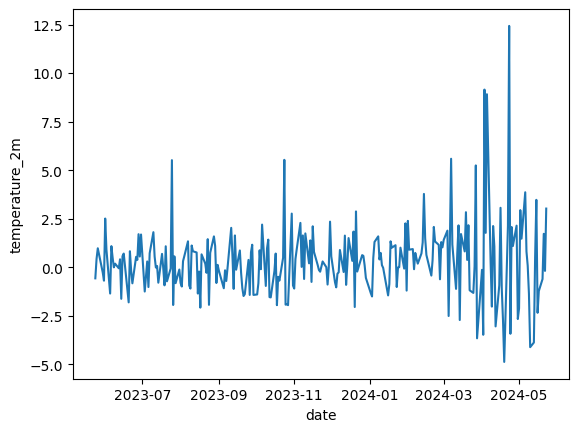

In [18]:
sns.lineplot(x='date',y='temperature_2m',data=df)

In [19]:
date_cutoff = '2024-01-31'
fine_tune_df = df[df['date'] < date_cutoff].reset_index(drop = True ).copy()
val_out_df = df[df['date'] >=  date_cutoff].reset_index(drop = True ).copy()


scaler = StandardScaler()
scaler = scaler.fit(fine_tune_df[['temperature_2m']])
fine_tune_df['temperature_2m'] = scaler.transform(fine_tune_df[['temperature_2m']])

In [20]:
val_df_perturb = val_out_df.copy()
val_df_perturb['temperature_2m_transformed'] = scaler.transform(val_df_perturb[['temperature_2m']])
val_df_perturb = perturb_outliers(val_df_perturb,perturb_cols = 0.1)

In [21]:
val_df_perturb[val_df_perturb['temperature_2m'] == 0]

,date,temperature_2m,temperature_2m_transformed
0,2024-01-31,0.0,0.0
3,2024-02-05,0.0,0.0
10,2024-02-14,0.0,0.0
11,2024-02-15,0.0,0.0
20,2024-02-29,0.0,0.0
59,2024-04-25,0.0,0.0
60,2024-04-26,0.0,0.0
66,2024-05-06,0.0,0.0


In [22]:
result_df = val_out_df[val_out_df['date'].isin(val_df_perturb[val_df_perturb['temperature_2m'] == 0].date)]
result_df = result_df.merge(impute(val_df_perturb,key = 1,sequence_length = 24), on = 'date')
result_df = result_df.merge(impute(val_df_perturb,key = 2,sequence_length = 24), on = 'date')
result_df = result_df.merge(impute(val_df_perturb,key = 3,sequence_length = 24,model = model, scaler = scaler), on = 'date')
result_df = result_df.merge(impute(val_df_perturb,key = 4,sequence_length = 24,model = model, scaler = scaler), on = 'date')
result_df.columns = ['date', 'Close','Close_simple_mean','Close_simple_median', 'Close_transformed_LSTM_AE_mean','Close_transformed_LSTM_AE_median']

2/2 [==============================] - 0s 5ms/step


In [23]:
result_df

,date,Close,Close_simple_mean,Close_simple_median,Close_transformed_LSTM_AE_mean,Close_transformed_LSTM_AE_median
0,2024-01-31,-1.205101,0.688453,0.734238,0.842319,0.842319
1,2024-02-05,0.933754,0.795018,0.818039,0.618258,0.634415
2,2024-02-14,3.774940,0.821050,0.941742,0.581683,0.604457
3,2024-02-15,1.492417,0.826029,1.045494,0.579155,0.586639
4,2024-02-29,1.021553,0.814365,1.149246,0.775381,0.819404
5,2024-04-25,2.069993,0.411008,-0.135666,1.580303,1.501472
6,2024-04-26,1.090011,0.391958,-0.116947,1.651859,1.663084
7,2024-05-06,3.860000,0.184592,-0.770004,-0.084147,-0.271754


### 📊 GE Data – Plot of True vs Imputed Values

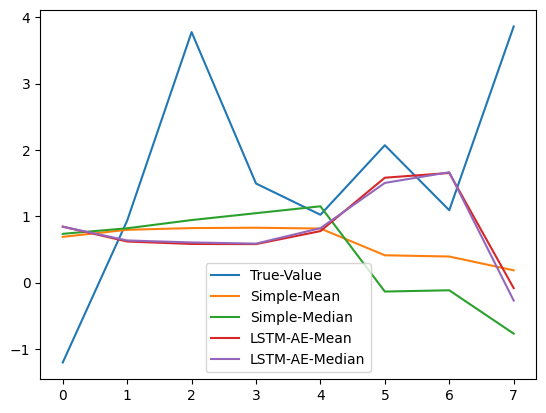

In [24]:
plt.plot(result_df['Close'], label='True-Value')
plt.plot(result_df['Close_simple_mean'], label='Simple-Mean')
plt.plot(result_df['Close_simple_median'], label='Simple-Median')
plt.plot(result_df['Close_transformed_LSTM_AE_mean'], label='LSTM-AE-Mean')
plt.plot(result_df['Close_transformed_LSTM_AE_median'], label='LSTM-AE-Median')
plt.legend();

### 📈 GE Data – RMSE Evaluation

In [25]:
print('simple mean imputation RMSE:')
print(np.sqrt(mean_squared_error(result_df.Close, result_df.Close_simple_mean)))
print('simple median imputation RMSE:')
print(np.sqrt(mean_squared_error(result_df.Close, result_df.Close_simple_median)))
print('LSTM AE mean imputation RMSE:')
print(np.sqrt(mean_squared_error(result_df.Close, result_df.Close_transformed_LSTM_AE_mean)))
print('LSTM AE median imputation RMSE:')
print(np.sqrt(mean_squared_error(result_df.Close, result_df.Close_transformed_LSTM_AE_median)))

simple mean imputation RMSE:
1.9224136025521157
simple median imputation RMSE:
2.22980096010801
LSTM AE mean imputation RMSE:
1.9841487930327328
LSTM AE median imputation RMSE:
2.028478862701617
